# Interconnect Churn Forecast

The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MaxAbsScaler
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
def check_duplicates(df):
    # Check for any duplicate rows
    duplicate_rows = df.duplicated().any()
    # Check for duplicate customerIDs
    duplicate_customerID = df['customerID'].duplicated().any()
    print(f"Duplicate rows: {duplicate_rows}, Duplicate customerID: {duplicate_customerID}")

# Contract DF

In [3]:
# File path on platform: /datasets/final_provider/
contract = pd.read_csv('/datasets/final_provider/contract.csv')
check_duplicates(contract)

Duplicate rows: False, Duplicate customerID: False


In [4]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')
contract['Churn'] = np.where(contract['EndDate'] == 'No', 0, 1) #Assigns 1 if end date is met
contract['EndDate'] = contract['EndDate'].replace('No', pd.NaT)
# Convert valid 'EndDate' entries to datetime
contract['EndDate'] = pd.to_datetime(contract['EndDate'], errors='coerce')

contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

categorical_features = ['Type', 'PaperlessBilling', 'PaymentMethod']

# One-hot encoding the categorical features and updating the original DataFrame
contract = pd.get_dummies(contract, columns=categorical_features, drop_first=True)

In [6]:
contract.head(5)

,customerID,BeginDate,EndDate,MonthlyCharges,TotalCharges,Churn,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,2020-01-01,NaT,29.85,29.85,0,0,0,1,0,1,0
1,5575-GNVDE,2017-04-01,NaT,56.95,1889.50,0,1,0,0,0,0,1
2,3668-QPYBK,2019-10-01,2019-12-01,53.85,108.15,1,0,0,1,0,0,1
3,7795-CFOCW,2016-05-01,NaT,42.30,1840.75,0,1,0,0,0,0,0
4,9237-HQITU,2019-09-01,2019-11-01,70.70,151.65,1,0,0,1,0,1,0


In [7]:
contract['Churn'].sum() / len(contract['Churn'])

0.2653698707936959

* Data set is imbalanced
* Boosting algorithms like XGBoost, LightGBM, and CatBoost work well with imbalanced data. 

In [8]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   customerID                             7043 non-null   object        
 1   BeginDate                              7043 non-null   datetime64[ns]
 2   EndDate                                1869 non-null   datetime64[ns]
 3   MonthlyCharges                         7043 non-null   float64       
 4   TotalCharges                           7032 non-null   float64       
 5   Churn                                  7043 non-null   int64         
 6   Type_One year                          7043 non-null   uint8         
 7   Type_Two year                          7043 non-null   uint8         
 8   PaperlessBilling_Yes                   7043 non-null   uint8         
 9   PaymentMethod_Credit card (automatic)  7043 non-null   uint8   

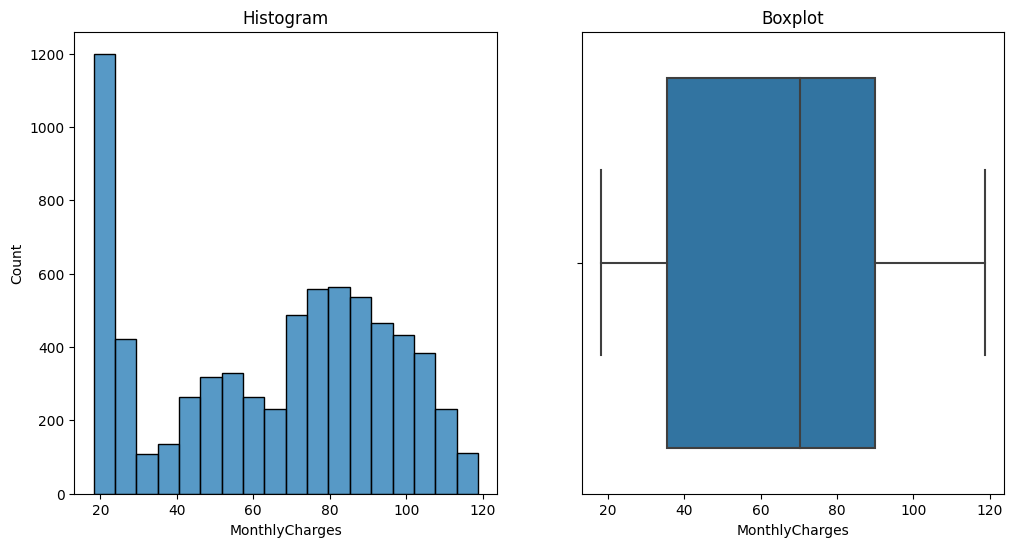

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Create a histogram on the first subplot
sns.histplot(contract['MonthlyCharges'], ax=axes[0])
axes[0].set_title("Histogram")

# Create a boxplot on the second subplot
sns.boxplot(x=contract['MonthlyCharges'], ax=axes[1])
axes[1].set_title("Boxplot")

# Display the plots
plt.show()

* Most people pay within 0-30 per month
* No noticable outliers

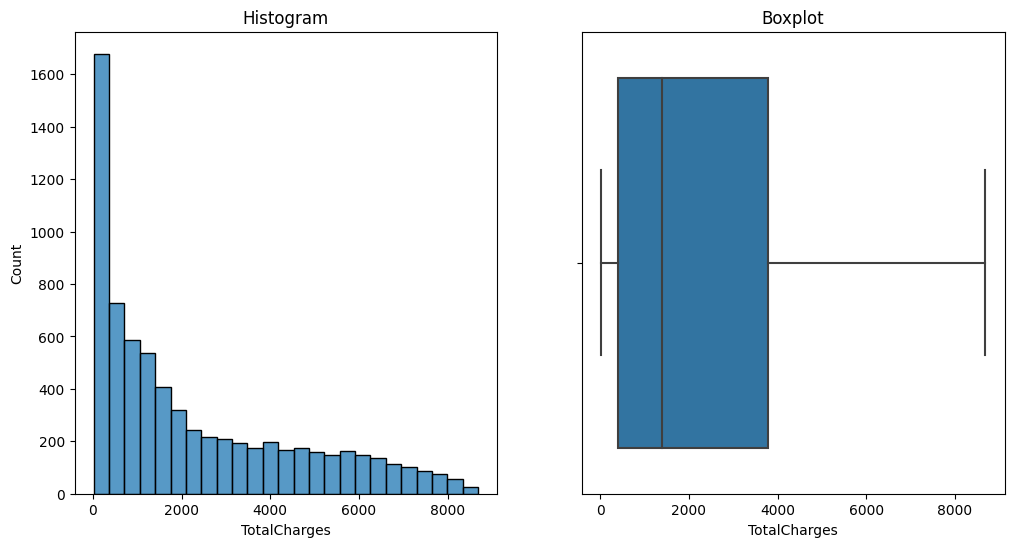

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Create a histogram on the first subplot
sns.histplot(contract['TotalCharges'], ax=axes[0])
axes[0].set_title("Histogram")

# Create a boxplot on the second subplot
sns.boxplot(x=contract['TotalCharges'], ax=axes[1])
axes[1].set_title("Boxplot")

# Display the plots
plt.show()

* No noticable outliers

In [11]:
bool_columns = contract.select_dtypes(include='bool')

# Calculate the percentage of True values for each boolean column
percentages = bool_columns.mean() * 100

# Display the result
print(percentages)

Series([], dtype: float64)


# Internet DF

In [12]:
internet = pd.read_csv('/datasets/final_provider/internet.csv')
check_duplicates(internet)

Duplicate rows: False, Duplicate customerID: False


In [13]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [14]:
categorical_features = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'  ]

# One-hot encoding the categorical features and updating the original DataFrame
internet = pd.get_dummies(internet, columns=categorical_features, drop_first=True)
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   customerID                   5517 non-null   object
 1   InternetService_Fiber optic  5517 non-null   uint8 
 2   OnlineSecurity_Yes           5517 non-null   uint8 
 3   OnlineBackup_Yes             5517 non-null   uint8 
 4   DeviceProtection_Yes         5517 non-null   uint8 
 5   TechSupport_Yes              5517 non-null   uint8 
 6   StreamingTV_Yes              5517 non-null   uint8 
 7   StreamingMovies_Yes          5517 non-null   uint8 
dtypes: object(1), uint8(7)
memory usage: 80.9+ KB


In [15]:
bool_columns = internet.select_dtypes(include='bool')

# Calculate the percentage of True values for each boolean column
percentages = bool_columns.mean() * 100

# Display the result
print(percentages)

Series([], dtype: float64)


# Personal DF

In [16]:
personal = pd.read_csv('/datasets/final_provider/personal.csv')
check_duplicates(internet)

Duplicate rows: False, Duplicate customerID: False


In [17]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [18]:
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

# One-hot encoding the categorical features and updating the original DataFrame
personal = pd.get_dummies(personal, columns=categorical_features, drop_first=True)
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   customerID       7043 non-null   object
 1   gender_Male      7043 non-null   uint8 
 2   SeniorCitizen_1  7043 non-null   uint8 
 3   Partner_Yes      7043 non-null   uint8 
 4   Dependents_Yes   7043 non-null   uint8 
dtypes: object(1), uint8(4)
memory usage: 82.7+ KB


In [19]:
bool_columns = personal.select_dtypes(include='bool')

# Calculate the percentage of True values for each boolean column
percentages = bool_columns.mean() * 100

# Display the result
print(percentages)

Series([], dtype: float64)


# Phone DF

In [20]:
phone = pd.read_csv('/datasets/final_provider/phone.csv')
check_duplicates(phone)

Duplicate rows: False, Duplicate customerID: False


In [21]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [22]:
phone = pd.get_dummies(phone, columns=['MultipleLines'], drop_first=True)
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customerID         6361 non-null   object
 1   MultipleLines_Yes  6361 non-null   uint8 
dtypes: object(1), uint8(1)
memory usage: 56.0+ KB


In [23]:
phone['MultipleLines_Yes'].value_counts(normalize=True) * 100

0    53.293507
1    46.706493
Name: MultipleLines_Yes, dtype: float64

# Combined DF

In [24]:
# Merging the DataFrames based on 'customerID'
combined_df = contract.merge(internet, on='customerID', how='left')\
                 .merge(personal, on='customerID', how='left')\
                 .merge(phone, on='customerID', how='left')

# Display the combined DataFrame
print(combined_df.head())

   customerID  BeginDate    EndDate  MonthlyCharges  TotalCharges  Churn  \
0  7590-VHVEG 2020-01-01        NaT           29.85         29.85      0   
1  5575-GNVDE 2017-04-01        NaT           56.95       1889.50      0   
2  3668-QPYBK 2019-10-01 2019-12-01           53.85        108.15      1   
3  7795-CFOCW 2016-05-01        NaT           42.30       1840.75      0   
4  9237-HQITU 2019-09-01 2019-11-01           70.70        151.65      1   

   Type_One year  Type_Two year  PaperlessBilling_Yes  \
0              0              0                     1   
1              1              0                     0   
2              0              0                     1   
3              1              0                     0   
4              0              0                     1   

   PaymentMethod_Credit card (automatic)  ...  OnlineBackup_Yes  \
0                                      0  ...               1.0   
1                                      0  ...               0.0   

In [25]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   customerID                             7043 non-null   object        
 1   BeginDate                              7043 non-null   datetime64[ns]
 2   EndDate                                1869 non-null   datetime64[ns]
 3   MonthlyCharges                         7043 non-null   float64       
 4   TotalCharges                           7032 non-null   float64       
 5   Churn                                  7043 non-null   int64         
 6   Type_One year                          7043 non-null   uint8         
 7   Type_Two year                          7043 non-null   uint8         
 8   PaperlessBilling_Yes                   7043 non-null   uint8         
 9   PaymentMethod_Credit card (automatic)  7043 non-null   uint8   

In [26]:
object_columns = ['OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes', 'MultipleLines_Yes', 'InternetService_Fiber optic']
combined_df[object_columns] = combined_df[object_columns].replace({'True': True, 'False': False}).astype(bool)

# Checking for Seasonality

In [27]:
min_date = combined_df['BeginDate'].min()
max_date = combined_df['BeginDate'].max()

print(f"Date range in the dataset is from {min_date} to {max_date}")

Date range in the dataset is from 2013-10-01 00:00:00 to 2020-02-01 00:00:00


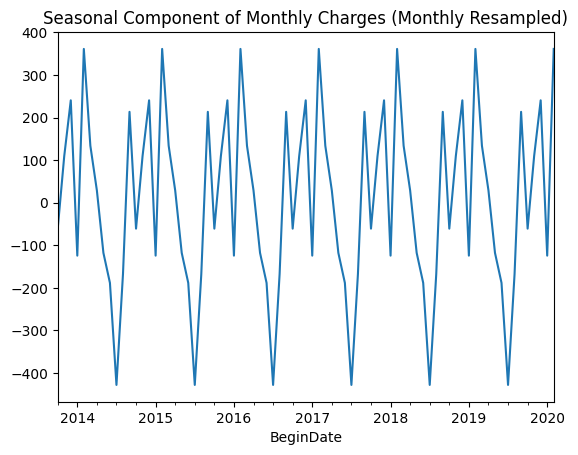

In [28]:
df = combined_df.set_index('BeginDate')

# Resample the data to monthly frequency, summing up 'MonthlyCharges'
df_resampled = df['MonthlyCharges'].resample('1M').sum()

# Perform seasonal decomposition on the resampled data
decomposed = seasonal_decompose(df_resampled, model='additive', period=12)  # Period of 12 for yearly seasonality

# Plot the seasonal component for a specific date range
decomposed.seasonal.plot()

# Show the plot
plt.title('Seasonal Component of Monthly Charges (Monthly Resampled)')
plt.show()

* Seasonality exists
* Add features to aid with boosting methods

In [29]:
max_date = max(contract['BeginDate'].max(), contract['EndDate'].max())

# Fill missing 'EndDate' values with the maximum date
combined_df['EndDate'].fillna(max_date, inplace=True)
# Calculate total days active (using max_date if EndDate is missing)
combined_df['days_active'] = (combined_df['EndDate'].fillna(max_date) - combined_df['BeginDate']).dt.days
# Calculate months active
combined_df['months_active'] = combined_df['days_active'] // 30  # Approximate to months
combined_df = combined_df.drop(columns=['EndDate'])

In [30]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   customerID                             7043 non-null   object        
 1   BeginDate                              7043 non-null   datetime64[ns]
 2   MonthlyCharges                         7043 non-null   float64       
 3   TotalCharges                           7032 non-null   float64       
 4   Churn                                  7043 non-null   int64         
 5   Type_One year                          7043 non-null   uint8         
 6   Type_Two year                          7043 non-null   uint8         
 7   PaperlessBilling_Yes                   7043 non-null   uint8         
 8   PaymentMethod_Credit card (automatic)  7043 non-null   uint8         
 9   PaymentMethod_Electronic check         7043 non-null   uint8   

# Proposed Work Plan: 
1. Download Data
2. Explore Data
   * The dataset contains 7043 entries, with 26.5% of the entries representing customers who have churned (indicating class imbalance).
   * Outliers are not present in the data set and data set data types have been adjusted for modeling.
   * All seperate dataframes have been combined into one and features have been added. Specifically, begin date and end date columns have been modified
     in order to aid the model in identifying whether or not a customer is likely to churn.
3. Apply machine learning models such as XGBoost, LightGBM, and CatBoost to predict customer churn.
4. Tune model hyperparameters using methods such as grid search or random search to optimize performance.
   * Modify or add features to improve the model's performance and aim to achieve an AUC-ROC score of ≥ 0.88.
5. Successfully identify whether a customer is likely to churn.
   * Use model predictions to inform business decisions, such as offering promotional codes or special plan options. 

# Solution Code

In [33]:
features = combined_df.drop(columns=['Churn', 'customerID', 'BeginDate'])  # Features
target = combined_df['Churn']                 # Target
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=12345)

In [34]:
from sklearn.metrics import confusion_matrix, roc_auc_score

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6],
    'n_estimators': [100, 200],
    'colsample_bytree': [0.7, 1],
    'subsample': [0.8, 1],
}

# Create the model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='auc')

# GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best parameters found: ", grid_search.best_params_)
print("Best ROC AUC score: ", grid_search.best_score_)

# Use the best model for prediction
best_model = grid_search.best_estimator_
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

# Convert probabilities to binary predictions (0 or 1)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_prob]

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate ROC AUC score on test data
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'Test ROC AUC: {roc_auc:.4f}')

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best parameters found:  {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1}
Best ROC AUC score:  0.887950496622879
Confusion Matrix:
[[977  53]
 [136 243]]
Test ROC AUC: 0.9018


1. What steps of the plan were performed and what steps were skipped (explain why)?
* All steps of the plan were performed, including data preprocessing, feature engineering, model selection, hyperparameter tuning, and evaluation. No steps were skipped
2. What difficulties did you encounter and how did you manage to solve them?
* The only difficulty I encountered was target leakage and I dropped the begindate column and included the days_active param and  months_active.
3. What were some of the key steps to solving the task?
* Feature engineering and one hot encoding are key steps and allowed me to reach a high ROC AUC score. 
4. What is your final model and what quality score does it have?
* The final model is XGBoost, which was optimized using GridSearchCV over 3 folds. The best parameters found were: colsample_bytree: 1, learning_rate: 0.1, max_depth: 6, n_estimators: 200, and subsample: 1. Test ROC AUC came in at 90%. 